<a href="https://colab.research.google.com/github/Vasyl808/deepfake_video_detection/blob/main/dfdc_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install facenet_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16

In [1]:
!unzip /content/drive/MyDrive/deepfake-detection-challenge.zip

Archive:  /content/drive/MyDrive/deepfake-detection-challenge.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test_videos/aassnaulhq.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import cv2
import itertools
import json
import numpy as np
import pandas as pd
import random
from torch.nn import functional as F
import os.path
import time
import torch
from torch import nn
from torch.nn import functional
import glob
import datetime
import subprocess
from scipy.io import wavfile
from facenet_pytorch import MTCNN
import shutil


class FaceDeepfakeDataset(torch.utils.data.Dataset):
    def __init__(self, folders, n_frames=None, n_audio_reads=50027, train=True, device=None, cache_folder='/content/cache'):
        """n_audio_reads controls the length of the audio sequence: 5000 readings/sec."""
        self.n_frames = n_frames
        self.n_audio_reads = n_audio_reads
        self.videos = []
        self.train = train
        self.device = device if device is not None else torch.device("cpu")
        self.cache_folder = cache_folder
        self.detector = MTCNN(device='cuda', post_process=False)

        # Створюємо директорію кешування, якщо вона не існує
        if cache_folder and not os.path.exists(cache_folder):
            os.makedirs(cache_folder)

        for i in range(len(folders)):
            if train:
                if i == 0:
                    with open('/content/train_sample_videos/metadata.json') as f:
                        videos = json.load(f)
                        videos = [(os.path.join(folders[i], video), metadata) for (video, metadata) in videos.items()]
                        self.videos += videos
                else:
                    with open(os.path.join("/content/test.json")) as f:
                        videos = json.load(f)
                        videos = [(os.path.join(folders[i], video), metadata) for (video, metadata) in videos.items()]
                        self.videos += videos
            else:
                self.videos += glob.glob(folders[i] + "/*.mp4")

    def __process_frame(self, frame, video_id, frame_idx):
        cache_path = os.path.join(self.cache_folder, f"{video_id}_frame{frame_idx}.pt") if self.cache_folder else None

        # Якщо файл з кешем існує, завантажуємо його
        if cache_path and os.path.exists(cache_path):
            return torch.load(cache_path)

        # Інакше обробляємо кадр
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, _ = self.detector.detect(frame, landmarks=False)

        if boxes is None:
            return None
        else:
            box = boxes[0]
            width = box[2] - box[0]
            height = box[3] - box[1]
            expand_x = width * 0.3 / 2
            expand_y = height * 0.3 / 2
            x1 = max(int(box[0] - expand_x), 0)
            y1 = max(int(box[1] - expand_y), 0)
            x2 = min(int(box[2] + expand_x), frame.shape[1])
            y2 = min(int(box[3] + expand_y), frame.shape[0])

            face = frame[y1:y2, x1:x2]
            face = cv2.resize(face, (300, 300))
            face = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0

            # Зберігаємо оброблений кадр у кеш
            if cache_path:
                torch.save(face, cache_path)

            return face

    def __pad_or_trim_frames(self, frames):
        if len(frames) == self.n_frames:
            return frames
        elif len(frames) < self.n_frames:
            # Дублюємо кадри, поки не досягнемо необхідної кількості
            num_repeats = (self.n_frames) // len(frames) + 1
            frames = frames * num_repeats
            frames = frames[:self.n_frames]
        elif len(frames) > self.n_frames:
            # Залишаємо тільки перші 30 кадрів
            frames = frames[:self.n_frames]
        return frames

    def __getitem__(self, n):
        if self.train:
            video, metadata = self.videos[n]
        else:
            video = self.videos[n]

        video_id = os.path.splitext(os.path.basename(video))[0]
        cap = cv2.VideoCapture(video)

        frames = []
        frame_idx = 0
        while len(frames) < self.n_frames:
            ret, frame = cap.read()
            if not ret:
                break

            processed_frame = self.__process_frame(frame, video_id, frame_idx)
            if processed_frame is not None:
                frames.append(processed_frame)
            frame_idx += 1

        cap.release()
        frames = self.__pad_or_trim_frames(frames)
        frames = torch.stack(frames).to(self.device)

        if self.train:
            label = 0.0 if metadata['label'] == 'REAL' else 1.0
            return frames, torch.FloatTensor([label]).to(self.device)
        else:
            return frames

    def __len__(self):
        return len(self.videos)

In [3]:
import torch
import torch.nn as nn
import math
from torch.nn import functional as F
import torchvision.models as models


class FaceClassifier(nn.Module):
    def __init__(self, n_linear_hidden=256, lstm_hidden_dim=128, num_lstm_layers=1, dropout=0.1):
        super(FaceClassifier, self).__init__()

        # Завантаження попередньо натренованої EfficientNet
        self.cnn = models.efficientnet_b7(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(self.cnn.children())[:-1])  # Виключаємо шар класифікації

        # Розмір виходу від feature extractor
        self.feature_output_size = 2560  # EfficientNet B7 дає 2560 ознак

        # LSTM для обробки послідовності ознак кожного кадру
        self.lstm = nn.LSTM(input_size=self.feature_output_size,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_lstm_layers,
                            batch_first=True,
                            bidirectional=True)

        # Повнозв'язні шари для класифікації
        self.fc1 = nn.Linear(2 * lstm_hidden_dim, n_linear_hidden)  # множимо на 2 через bidirectional LSTM
        self.fc2 = nn.Linear(n_linear_hidden, 1)

    def forward(self, vid_frames):
        # Витягання ознак для кожного кадру
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        # Використовуємо фічерний екстрактор
        with torch.no_grad():
            vid_features = self.feature_extractor(vid_frames)

        # Переформатовуємо ознаки для LSTM
        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        # Обробка послідовності кадрів через LSTM
        lstm_out, _ = self.lstm(vid_features)  # lstm_out: (batch_size, num_frames, 2 * lstm_hidden_dim)

        # Використання середнього значення по кадрам для об'єднання послідовності (можна також використовувати останній кадр або інші методи агрегації)
        lstm_out = torch.mean(lstm_out, dim=1)  # (batch_size, 2 * lstm_hidden_dim)

        # Класифікаційні шари
        x = torch.relu(self.fc1(lstm_out))
        x = self.fc2(x)

        return x

In [4]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import datetime
import sys
import pandas as pd
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision

base_path = 'deepfake-detection-challenge'

#train_folder = os.listdir(str(sys.argv[1]))
train_folders = ['/content/train_sample_videos', '/content/test_videos']


#test_folder = os.listdir(str(sys.argv[2]))
test_folders = ['/content/train_sample_videos', '/content/test_videos']

batch_size = int(8)
num_epochs = int(5)
n_frames = int(30)
lr = float(0.001)

TRAIN_FOLDERS = train_folders
TEST_FOLDERS = test_folders
print(f"all train folders: {train_folders}, {type(train_folders)}")
print(f"all test folders: {test_folders}, {type(test_folders)}")
# AUTOENCODER = 'autoencoder_H10M46S22_04-11-21.pt'

# batch_size = 10
# num_epochs = 1
# epoch_size = 500
# n_frames = 30
milestones = [6,12,18]
gamma = 0.1
n_vid_features = 36*36 # 3600
n_aud_features = 1
n_head = 8
n_layers = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#autoencoder = FaceAutoencoder()
#if len(sys.argv) > 7:
#    print("pretrained autoencoder is loaded")
#    AUTOENCODER = str(sys.argv[7])
#    autoencoder.load_state_dict(torch.load(AUTOENCODER, map_location=device))
#autoencoder.to(device)
#autoencoder.eval()

model = FaceClassifier()
model.load_state_dict(torch.load('/content/4_classifier_30_small.pt', map_location=device))
model = model.to(device)
class_weights = {0: 0.6191950464396285, 1: 2.5974025974025974}
weights_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32).to(device)

# Modify the loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

start_time = datetime.datetime.now()
print(f'start time: {str(start_time)}')
print(f'using device: {device}')

'''Splitting into Train and Validation'''
train_dataset = FaceDeepfakeDataset(TRAIN_FOLDERS,  n_frames=n_frames, n_audio_reads=576, device=device, cache_folder="face_encode_cache")
#test_dataset = FaceDeepfakeDataset(TEST_FOLDERS, n_frames=n_frames, n_audio_reads=576, device=device)
# dataset_size = len(dataset)
# val_split = .3
# val_size = int(val_split * dataset_size)
# train_size = dataset_size - val_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(len(train_loader))
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

'''Train_Loop'''
train_losses = []
val_losses = []
best_loss = np.inf
train_accuracies = []
val_accuracies = []
epoch_times = []


for epoch in range(num_epochs):
    epoch_start_time = time.time()
    epoch_t_loss = 0
    epoch_v_loss = 0
    t_count = 0
    t_count_wrong = 0
    train_labels_all = []
    train_preds_all = []

    model.train()
    torch.cuda.empty_cache()
    for i, batch in tqdm(enumerate(train_loader)):
        # if i * batch_size >= epoch_size:
        #     break
        video_data, labels = batch
        video_data = video_data.to(device)
        #audio_data = audio_data.to(device)

        output = model(video_data)
        loss = criterion(output, labels)

        output = torch.sigmoid(output)
        output = output.round()

        n_wrong = (labels - output).abs().sum()
        t_count_wrong += n_wrong
        t_count += labels.shape[0]

        epoch_t_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_labels_all.extend(labels.cpu().detach().numpy())
        train_preds_all.extend(output.cpu().detach().numpy())

        #print('.', end='', flush=True)
        torch.cuda.empty_cache()

    # Перетворіть на numpy-масиви
    train_labels_all = np.array(train_labels_all).astype(int)
    train_preds_all = np.array(train_preds_all).astype(int)

    # Обчисліть та виведіть матрицю плутанини для тренувального набору
    conf_matrix_train = confusion_matrix(train_labels_all, train_preds_all)
    print(conf_matrix_train)
    # plt.figure(figsize=(8, 6))
    #sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    #plt.xlabel('Predicted Label')
    #plt.ylabel('True Label')
    #plt.title('Confusion Matrix (Train Set)')
    #plt.show()

    # Виведіть класифікаційний звіт для тренувального набору
    print("Classification Report (Train Set):")
    print(classification_report(train_labels_all, train_preds_all, target_names=['Real', 'Fake']))

    #all_labels = []
    #all_preds = []

    #model.eval()
    #with torch.no_grad():
    #    v_count = 0
    #    v_count_wrong = 0
    #    for i, batch in enumerate(val_loader):
            # if i * batch_size >= epoch_size:
        #        break
   #         video_data, labels = batch
   #         video_data = video_data.to(device)
            #audio_data = audio_data.to(device)
            # optimizer.zero_grad()
  #          output = model(video_data)
  #          loss = criterion(output, labels)

            #output = torch.sigmoid(output)
            #output = output.round()
            #n_wrong = (labels - output).abs().sum()
            #v_count_wrong += n_wrong
            #v_count += labels.shape[0]

            #epoch_v_loss += loss.item()

            #all_labels.extend(labels.cpu().numpy())
            #all_preds.extend(output.cpu().numpy())

            # loss.backward()
            # optimizer.step()
            #print('.', end='', flush=True)

    epoch_end_time = time.time()
    epoch_exec_time = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_exec_time)
    train_losses.append(epoch_t_loss/len(train_loader))
    #val_losses.append(epoch_t_loss/len(val_loader))

    t_count_right = t_count - t_count_wrong
    #v_count_right = v_count - v_count_wrong
    t_accuracy = t_count_right / t_count
    #v_accuracy = v_count_right / v_count

    train_accuracies.append(t_accuracy)
    #val_accuracies.append(v_accuracy)

    print(f'\nepoch: {epoch}, train loss: {train_losses[-1]}, executed in: {str(epoch_exec_time)}')
    print(f"train total: {t_count}, train correct: {t_count_right}, train incorrect: {t_count_wrong}, train accuracy: {t_accuracy}")
    #print(f"valid total: {v_count}, valid correct: {v_count_right}, valid incorrect: {v_count_wrong}, valid accuracy: {v_accuracy}")
    #all_labels = np.array(all_labels).astype(int)
    #all_preds = np.array(all_preds).astype(int)
    # Обчислення та візуалізація матриці плутанини
    #conf_matrix = confusion_matrix(all_labels, all_preds)
    #print(conf_matrix)
    #plt.figure(figsize=(8, 6))
    #sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    #plt.xlabel('Predicted Label')
    #plt.ylabel('True Label')
    #plt.title('Confusion Matrix')
    #plt.show()

    # Друк звіту про класифікацію
    #print("Classification Report:")
    #print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

    #scheduler.step()
    ### Saving model per best validation loss
    if best_loss > train_losses[-1]:
        best_loss = train_losses[-1]
        end_time = datetime.datetime.now()
        torch.save(model.state_dict(), f'/content/drive/MyDrive/{epoch}_classifier_{n_frames}_small.pt')


end_time = datetime.datetime.now()
print(f"end time: {str(end_time)}")
exec_time = end_time - start_time
print(f"executed in: {str(exec_time)}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

#df = pd.DataFrame()
#df['train_loss'] = train_losses.cpu().numpy()
#df['val_loss'] = val_losses.cpu().numpy()
#df['train_acc'] = train_accuracies.cpu().numpy()
#df['val_acc'] = val_accuracies.cpu().numpy()
#df['epoch_times'] = epoch_times

#df.to_csv(f'train_classifier_nframes{n_frames}_bs{batch_size}_lr{lr}.csv', index=False)


all train folders: ['/content/train_sample_videos', '/content/test_videos'], <class 'list'>
all test folders: ['/content/train_sample_videos', '/content/test_videos'], <class 'list'>


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:02<00:00, 132MB/s]


start time: 2024-11-06 14:35:40.834613
using device: cuda
100


100it [1:00:26, 36.26s/it]


[[448  29]
 [ 16 307]]
Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.97      0.94      0.95       477
        Fake       0.91      0.95      0.93       323

    accuracy                           0.94       800
   macro avg       0.94      0.94      0.94       800
weighted avg       0.94      0.94      0.94       800


epoch: 0, train loss: 0.14641888292972, executed in: 3626.3428843021393
train total: 800, train correct: 755.0, train incorrect: 45.0, train accuracy: 0.9437499642372131


100it [20:39, 12.40s/it]


[[455  22]
 [ 12 311]]
Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.97      0.95      0.96       477
        Fake       0.93      0.96      0.95       323

    accuracy                           0.96       800
   macro avg       0.95      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800


epoch: 1, train loss: 0.1102919635293074, executed in: 1239.8142051696777
train total: 800, train correct: 766.0, train incorrect: 34.0, train accuracy: 0.9574999809265137


100it [20:29, 12.30s/it]


[[462  15]
 [ 15 308]]
Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.97      0.97      0.97       477
        Fake       0.95      0.95      0.95       323

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800


epoch: 2, train loss: 0.08927351533668115, executed in: 1230.0214631557465
train total: 800, train correct: 770.0, train incorrect: 30.0, train accuracy: 0.9624999761581421


100it [20:41, 12.42s/it]


[[458  19]
 [ 11 312]]
Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.98      0.96      0.97       477
        Fake       0.94      0.97      0.95       323

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800


epoch: 3, train loss: 0.10506657025427557, executed in: 1242.0170331001282
train total: 800, train correct: 770.0, train incorrect: 30.0, train accuracy: 0.9624999761581421


100it [20:51, 12.51s/it]


[[460  17]
 [ 12 311]]
Classification Report (Train Set):
              precision    recall  f1-score   support

        Real       0.97      0.96      0.97       477
        Fake       0.95      0.96      0.96       323

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800


epoch: 4, train loss: 0.07326189557847101, executed in: 1251.4552285671234
train total: 800, train correct: 771.0, train incorrect: 29.0, train accuracy: 0.9637500047683716
end time: 2024-11-06 16:58:56.990695
executed in: 2:23:16.156082
Tesla T4
Memory Usage:
Allocated: 0.6 GB
Cached:    0.8 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:440: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [8]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/10_epochs_classifier_30_small_batch_8_dfdc.pt')

In [5]:
!unzip /content/archive_uadfv.zip

Archive:  /content/archive_uadfv.zip
  inflating: fake_videos/test/fake/0046_fake.mp4  
  inflating: fake_videos/test/fake/0047_fake.mp4  
  inflating: fake_videos/test/fake/0048_fake.mp4  
  inflating: fake_videos/test/real/0046.mp4  
  inflating: fake_videos/test/real/0047.mp4  
  inflating: fake_videos/test/real/0048.mp4  
  inflating: fake_videos/train/fake/0000_fake.mp4  
  inflating: fake_videos/train/fake/0001_fake.mp4  
  inflating: fake_videos/train/fake/0002_fake.mp4  
  inflating: fake_videos/train/fake/0003_fake.mp4  
  inflating: fake_videos/train/fake/0004_fake.mp4  
  inflating: fake_videos/train/fake/0005_fake.mp4  
  inflating: fake_videos/train/fake/0006_fake.mp4  
  inflating: fake_videos/train/fake/0007_fake.mp4  
  inflating: fake_videos/train/fake/0008_fake.mp4  
  inflating: fake_videos/train/fake/0009_fake.mp4  
  inflating: fake_videos/train/fake/0010_fake.mp4  
  inflating: fake_videos/train/fake/0011_fake.mp4  
  inflating: fake_videos/train/fake/0012_fake.mp

In [9]:
class FaceDeepfakeDataset(torch.utils.data.Dataset):
    def __init__(self, folders, n_frames=None, n_audio_reads=50027, train=True, device=None, cache_folder=None):
        """n_audio_reads controls the length of the audio sequence: 5000 readings/sec."""
        self.n_frames = n_frames
        self.n_audio_reads = n_audio_reads
        self.videos = []
        self.train = train
        self.device = device if device is not None else torch.device("cpu")
        self.cache_folder = cache_folder
        self.detector = MTCNN(device='cpu', post_process=False)
        for i in range(len(folders)):
            if train:
                #print(folders[i])
                for item in os.listdir(folders[i]):
                    item_path = os.path.join(folders[i], item)
                    if str(os.path.basename(item_path)) == 'fake':
                        for curr in os.listdir(item_path):
                            if os.path.isfile(os.path.join(item_path, curr)):
                                metadata = {}
                                metadata['label']='fake'
                                self.videos += [(os.path.join(item_path, curr), metadata)]
                    else:
                        for item_file in os.listdir(item_path):
                            if os.path.isfile(os.path.join(item_path, item_file)):
                                metadata = {}
                                metadata['label']='real'
                                self.videos += [(os.path.join(item_path, item_file), metadata)]
            else:
                self.videos += glob.glob(folders[i] + "/*.mp4")

    def __process_frame(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, _ = self.detector.detect(frame, landmarks=False)  # Отримуємо координати обличчя

        if boxes is None:
            # Повертаємо порожній кадр, якщо обличчя не знайдено
            face = torch.zeros((3, 300, 300))
        else:
            # Беремо перше обличчя (якщо знайдено кілька)
            box = boxes[0]

            # Розширюємо рамку на 30%
            width = box[2] - box[0]
            height = box[3] - box[1]
            expand_x = width * 0.3 / 2
            expand_y = height * 0.3 / 2
            x1 = max(int(box[0] - expand_x), 0)
            y1 = max(int(box[1] - expand_y), 0)
            x2 = min(int(box[2] + expand_x), frame.shape[1])
            y2 = min(int(box[3] + expand_y), frame.shape[0])

            # Обрізаємо зображення за новими координатами
            face = frame[y1:y2, x1:x2]
            face = cv2.resize(face, (300, 300))  # Масштабуємо до 300x300

            # Перетворюємо на тензор і нормалізуємо
            face = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0

        return face

    def __getitem__(self, n):
        if self.train:
            video, metadata = self.videos[n]
        else:
            video = self.videos[n]

        # Processing video frames
        if os.path.islink(video):
            video = os.readlink(video)

        cap = cv2.VideoCapture(video)

        frames = []
        for _ in range(self.n_frames):
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(self.__process_frame(frame))
        '''total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = max(1, total_frames // self.n_frames)

        for i in range(self.n_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
            ret, frame = cap.read()
            if ret:
                frames.append(self.__process_frame(frame))
            else:
                break'''
        cap.release()
        frames = torch.stack(frames).to(self.device)

        # Return data
        if self.train:
            label = 0.0
            if metadata['label'] == 'fake':
                label = 1.0
            return frames, torch.FloatTensor([label]).to(self.device)
        else:
            return frames

    def __len__(self):
        return len(self.videos)


'''def __process_frame(self, frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    boxes, _ = self.detector.detect(frame, landmarks=False)  # Отримуємо координати обличчя

    if boxes is None:
        # Повертаємо None, якщо обличчя не знайдено
        return None
    else:
        # Беремо перше обличчя (якщо знайдено кілька)
        box = boxes[0]

        # Розширюємо рамку на 30%
        width = box[2] - box[0]
        height = box[3] - box[1]
        expand_x = width * 0.3 / 2
        expand_y = height * 0.3 / 2
        x1 = max(int(box[0] - expand_x), 0)
        y1 = max(int(box[1] - expand_y), 0)
        x2 = min(int(box[2] + expand_x), frame.shape[1])
        y2 = min(int(box[3] + expand_y), frame.shape[0])

        # Обрізаємо зображення за новими координатами
        face = frame[y1:y2, x1:x2]
        face = cv2.resize(face, (300, 300))  # Масштабуємо до 300x300

        # Перетворюємо на тензор і нормалізуємо
        face = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0

        return face

def __getitem__(self, n):
    if self.train:
        video, metadata = self.videos[n]
    else:
        video = self.videos[n]

    # Processing video frames
    if os.path.islink(video):
        video = os.readlink(video)

    cap = cv2.VideoCapture(video)

    frames = []
    while len(frames) < self.n_frames:
        ret, frame = cap.read()
        if not ret:
            # Якщо дійшли до кінця відео, повертаємось на початок
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            continue

        processed_frame = self.__process_frame(frame)
        if processed_frame is not None:
            frames.append(processed_frame)

    cap.release()
    frames = torch.stack(frames).to(self.device)

    # Return data
    if self.train:
        label = 0.0
        if metadata['label'] == 'fake':
            label = 1.0
        return frames, torch.FloatTensor([label]).to(self.device)
    else:
        return frames

def __len__(self):
    return len(self.videos)'''

"def __process_frame(self, frame):\n    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)\n    boxes, _ = self.detector.detect(frame, landmarks=False)  # Отримуємо координати обличчя\n\n    if boxes is None:\n        # Повертаємо None, якщо обличчя не знайдено\n        return None\n    else:\n        # Беремо перше обличчя (якщо знайдено кілька)\n        box = boxes[0]\n\n        # Розширюємо рамку на 30%\n        width = box[2] - box[0]\n        height = box[3] - box[1]\n        expand_x = width * 0.3 / 2\n        expand_y = height * 0.3 / 2\n        x1 = max(int(box[0] - expand_x), 0)\n        y1 = max(int(box[1] - expand_y), 0)\n        x2 = min(int(box[2] + expand_x), frame.shape[1])\n        y2 = min(int(box[3] + expand_y), frame.shape[0])\n\n        # Обрізаємо зображення за новими координатами\n        face = frame[y1:y2, x1:x2]\n        face = cv2.resize(face, (300, 300))  # Масштабуємо до 300x300\n\n        # Перетворюємо на тензор і нормалізуємо\n        face = torch.from_numpy(

In [10]:
import cv2
import itertools
import json
import numpy as np
import pandas as pd
import random
from torch.nn import functional as F
import os.path
import time
import torch
from torch import nn
from torch.nn import functional
import glob
import datetime
import subprocess
from facenet_pytorch import MTCNN
import shutil
import torchvision.transforms.functional as TF


class FaceClassifier(nn.Module):
    def __init__(self, n_linear_hidden=256, lstm_hidden_dim=128, num_lstm_layers=1, dropout=0.1):
        super(FaceClassifier, self).__init__()

        # Завантаження попередньо натренованої EfficientNet
        self.cnn = models.efficientnet_b7(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(self.cnn.children())[:-1])  # Виключаємо шар класифікації

        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        # Розмір виходу від feature extractor
        self.feature_output_size = 2560  # EfficientNet B7 дає 2560 ознак

        # LSTM для обробки послідовності ознак кожного кадру
        self.lstm = nn.LSTM(input_size=self.feature_output_size,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_lstm_layers,
                            batch_first=True,
                            bidirectional=True)

        # Повнозв'язні шари для класифікації
        self.fc1 = nn.Linear(2 * lstm_hidden_dim, n_linear_hidden)  # множимо на 2 через bidirectional LSTM
        self.fc2 = nn.Linear(n_linear_hidden, 1)

    def forward(self, vid_frames):
        # Витягання ознак для кожного кадру
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        # Використовуємо фічерний екстрактор
        with torch.no_grad():
            vid_features = self.feature_extractor(vid_frames)

        # Переформатовуємо ознаки для LSTM
        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        # Обробка послідовності кадрів через LSTM
        lstm_out, _ = self.lstm(vid_features)  # lstm_out: (batch_size, num_frames, 2 * lstm_hidden_dim)

        # Використання середнього значення по кадрам для об'єднання послідовності (можна також використовувати останній кадр або інші методи агрегації)
        lstm_out = torch.mean(lstm_out, dim=1)  # (batch_size, 2 * lstm_hidden_dim)

        # Класифікаційні шари
        x = torch.relu(self.fc1(lstm_out))
        x = self.fc2(x)

        return x


10 epocs

all train folders: ['/content/fake_videos/train'], <class 'list'>
all test folders: ['/content/fake_videos/train'], <class 'list'>


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


start time: 2024-11-06 17:02:23.846056
using device: cuda
82


82it [06:29,  4.74s/it]



epoch: 0, val loss: 0.0, executed in: 389.0905051231384
valid total: 82, valid correct: 41.0, valid incorrect: 41.0, valid accuracy: 0.4999999701976776


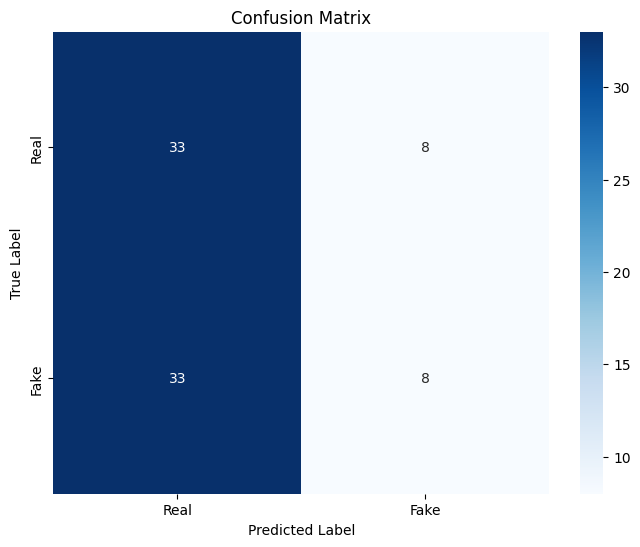

Classification Report:
              precision    recall  f1-score   support

        Real       0.50      0.80      0.62        41
        Fake       0.50      0.20      0.28        41

    accuracy                           0.50        82
   macro avg       0.50      0.50      0.45        82
weighted avg       0.50      0.50      0.45        82

end time: 2024-11-06 17:08:53.346494
executed in: 0:06:29.500438
Tesla T4
Memory Usage:
Allocated: 0.3 GB
Cached:    2.2 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:440: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [11]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import datetime
import sys
import pandas as pd
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import models

base_path = 'deepfake-detection-challenge'

#train_folder = os.listdir(str(sys.argv[1]))
train_folders = [os.path.join("/content/", "fake_videos", "train")]


#test_folder = os.listdir(str(sys.argv[2]))
test_folders = [os.path.join("/content/", "fake_videos", "train")]

batch_size = int(1)
num_epochs = int(10)
n_frames = int(30)
lr = float(0.001)

TRAIN_FOLDERS = train_folders
TEST_FOLDERS = test_folders
print(f"all train folders: {train_folders}, {type(train_folders)}")
print(f"all test folders: {test_folders}, {type(test_folders)}")
# AUTOENCODER = 'autoencoder_H10M46S22_04-11-21.pt'

# batch_size = 10
# num_epochs = 1
# epoch_size = 500
# n_frames = 30
milestones = [6,12,18]
gamma = 0.1
n_vid_features = 36*36 # 3600
n_aud_features = 1
n_head = 8
n_layers = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#autoencoder = FaceAutoencoder()
#if len(sys.argv) > 7:
#    print("pretrained autoencoder is loaded")
#    AUTOENCODER = str(sys.argv[7])
#    autoencoder.load_state_dict(torch.load(AUTOENCODER, map_location=device))
#autoencoder.to(device)
#autoencoder.eval()

model = FaceClassifier()
model.load_state_dict(torch.load('/content/drive/MyDrive/10_epochs_classifier_30_small_batch_8_dfdc.pt', map_location=device))

model = model.to(device)
class_weights = {0: 0.6191950464396285, 1: 2.5974025974025974}
weights_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32).to(device)

# Modify the loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

start_time = datetime.datetime.now()
print(f'start time: {str(start_time)}')
print(f'using device: {device}')

'''Splitting into Train and Validation'''
train_dataset = FaceDeepfakeDataset(TRAIN_FOLDERS,  n_frames=n_frames, n_audio_reads=576, device=device, cache_folder="face_encode_cache")
test_dataset = FaceDeepfakeDataset(TEST_FOLDERS, n_frames=n_frames, n_audio_reads=576, device=device)
# dataset_size = len(dataset)
# val_split = .3
# val_size = int(val_split * dataset_size)
# train_size = dataset_size - val_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(len(train_loader))
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

'''Train_Loop'''
train_losses = []
val_losses = []
best_loss = np.inf
train_accuracies = []
val_accuracies = []
epoch_times = []


for epoch in range(1):
    epoch_start_time = time.time()
    epoch_t_loss = 0
    epoch_v_loss = 0
    t_count = 0
    t_count_wrong = 0
    train_labels_all = []
    train_preds_all = []

    all_labels = []
    all_preds = []

    model.eval()
    with torch.no_grad():
        v_count = 0
        v_count_wrong = 0
        for i, batch in tqdm(enumerate(val_loader)):
            # if i * batch_size >= epoch_size:
        #        break
            video_data, labels = batch
            video_data = video_data.to(device)
            #audio_data = audio_data.to(device)
            # optimizer.zero_grad()
            output = model(video_data)
            loss = criterion(output, labels)

            output = torch.sigmoid(output)
            output = output.round()
            n_wrong = (labels - output).abs().sum()
            v_count_wrong += n_wrong
            v_count += labels.shape[0]

            epoch_v_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(output.cpu().numpy())

            # loss.backward()
            # optimizer.step()
            #print('.', end='', flush=True)

    epoch_end_time = time.time()
    epoch_exec_time = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_exec_time)
    val_losses.append(epoch_t_loss/len(val_loader))

    v_count_right = v_count - v_count_wrong
    v_accuracy = v_count_right / v_count

    val_accuracies.append(v_accuracy)

    print(f'\nepoch: {epoch}, val loss: {val_losses[-1]}, executed in: {str(epoch_exec_time)}')
    #print(f"train total: {t_count}, train correct: {t_count_right}, train incorrect: {t_count_wrong}, train accuracy: {t_accuracy}")
    print(f"valid total: {v_count}, valid correct: {v_count_right}, valid incorrect: {v_count_wrong}, valid accuracy: {v_accuracy}")
    all_labels = np.array(all_labels).astype(int)
    all_preds = np.array(all_preds).astype(int)
    # Обчислення та візуалізація матриці плутанини
    conf_matrix = confusion_matrix(all_labels, all_preds)
    #print(conf_matrix)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Друк звіту про класифікацію
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))



end_time = datetime.datetime.now()
print(f"end time: {str(end_time)}")
exec_time = end_time - start_time
print(f"executed in: {str(exec_time)}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')



8 epocs

all train folders: ['/content/fake_videos/train'], <class 'list'>
all test folders: ['/content/fake_videos/train'], <class 'list'>
start time: 2024-11-06 17:09:51.090149
using device: cuda
82


82it [06:28,  4.74s/it]



epoch: 0, val loss: 0.0, executed in: 388.4746015071869
valid total: 82, valid correct: 46.0, valid incorrect: 36.0, valid accuracy: 0.5609756112098694


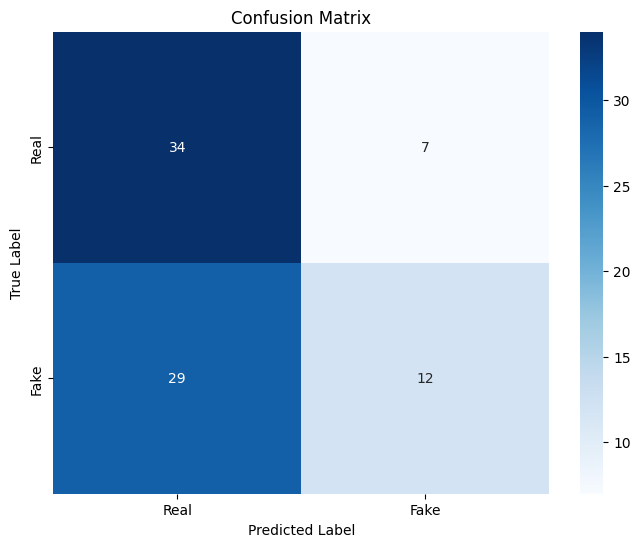

Classification Report:
              precision    recall  f1-score   support

        Real       0.54      0.83      0.65        41
        Fake       0.63      0.29      0.40        41

    accuracy                           0.56        82
   macro avg       0.59      0.56      0.53        82
weighted avg       0.59      0.56      0.53        82

end time: 2024-11-06 17:16:19.844527
executed in: 0:06:28.754378
Tesla T4
Memory Usage:
Allocated: 0.3 GB
Cached:    2.2 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:440: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [13]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import datetime
import sys
import pandas as pd
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import models

base_path = 'deepfake-detection-challenge'

#train_folder = os.listdir(str(sys.argv[1]))
train_folders = [os.path.join("/content/", "fake_videos", "train")]


#test_folder = os.listdir(str(sys.argv[2]))
test_folders = [os.path.join("/content/", "fake_videos", "train")]

batch_size = int(1)
num_epochs = int(10)
n_frames = int(30)
lr = float(0.001)

TRAIN_FOLDERS = train_folders
TEST_FOLDERS = test_folders
print(f"all train folders: {train_folders}, {type(train_folders)}")
print(f"all test folders: {test_folders}, {type(test_folders)}")
# AUTOENCODER = 'autoencoder_H10M46S22_04-11-21.pt'

# batch_size = 10
# num_epochs = 1
# epoch_size = 500
# n_frames = 30
milestones = [6,12,18]
gamma = 0.1
n_vid_features = 36*36 # 3600
n_aud_features = 1
n_head = 8
n_layers = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#autoencoder = FaceAutoencoder()
#if len(sys.argv) > 7:
#    print("pretrained autoencoder is loaded")
#    AUTOENCODER = str(sys.argv[7])
#    autoencoder.load_state_dict(torch.load(AUTOENCODER, map_location=device))
#autoencoder.to(device)
#autoencoder.eval()

model = FaceClassifier()
model.load_state_dict(torch.load('/content/drive/MyDrive/2_classifier_30_small.pt', map_location=device))

model = model.to(device)
class_weights = {0: 0.6191950464396285, 1: 2.5974025974025974}
weights_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32).to(device)

# Modify the loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

start_time = datetime.datetime.now()
print(f'start time: {str(start_time)}')
print(f'using device: {device}')

'''Splitting into Train and Validation'''
train_dataset = FaceDeepfakeDataset(TRAIN_FOLDERS,  n_frames=n_frames, n_audio_reads=576, device=device, cache_folder="face_encode_cache")
test_dataset = FaceDeepfakeDataset(TEST_FOLDERS, n_frames=n_frames, n_audio_reads=576, device=device)
# dataset_size = len(dataset)
# val_split = .3
# val_size = int(val_split * dataset_size)
# train_size = dataset_size - val_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(len(train_loader))
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

'''Train_Loop'''
train_losses = []
val_losses = []
best_loss = np.inf
train_accuracies = []
val_accuracies = []
epoch_times = []


for epoch in range(1):
    epoch_start_time = time.time()
    epoch_t_loss = 0
    epoch_v_loss = 0
    t_count = 0
    t_count_wrong = 0
    train_labels_all = []
    train_preds_all = []

    all_labels = []
    all_preds = []

    model.eval()
    with torch.no_grad():
        v_count = 0
        v_count_wrong = 0
        for i, batch in tqdm(enumerate(val_loader)):
            # if i * batch_size >= epoch_size:
        #        break
            video_data, labels = batch
            video_data = video_data.to(device)
            #audio_data = audio_data.to(device)
            # optimizer.zero_grad()
            output = model(video_data)
            loss = criterion(output, labels)

            output = torch.sigmoid(output)
            output = output.round()
            n_wrong = (labels - output).abs().sum()
            v_count_wrong += n_wrong
            v_count += labels.shape[0]

            epoch_v_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(output.cpu().numpy())

            # loss.backward()
            # optimizer.step()
            #print('.', end='', flush=True)

    epoch_end_time = time.time()
    epoch_exec_time = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_exec_time)
    val_losses.append(epoch_t_loss/len(val_loader))

    v_count_right = v_count - v_count_wrong
    v_accuracy = v_count_right / v_count

    val_accuracies.append(v_accuracy)

    print(f'\nepoch: {epoch}, val loss: {val_losses[-1]}, executed in: {str(epoch_exec_time)}')
    #print(f"train total: {t_count}, train correct: {t_count_right}, train incorrect: {t_count_wrong}, train accuracy: {t_accuracy}")
    print(f"valid total: {v_count}, valid correct: {v_count_right}, valid incorrect: {v_count_wrong}, valid accuracy: {v_accuracy}")
    all_labels = np.array(all_labels).astype(int)
    all_preds = np.array(all_preds).astype(int)
    # Обчислення та візуалізація матриці плутанини
    conf_matrix = confusion_matrix(all_labels, all_preds)
    #print(conf_matrix)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Друк звіту про класифікацію
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))



end_time = datetime.datetime.now()
print(f"end time: {str(end_time)}")
exec_time = end_time - start_time
print(f"executed in: {str(exec_time)}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

